## Result

#### R2 score for Minimum Temperature: 0.936
#### R2 score for Maximum Temperature: 0.956
#### R2 score for Pressure: 0.950
#### R2 score for Wind Speed: 0.999

In [30]:
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings("ignore")

In [13]:
con = duckdb.connect('Earth.duckdb')

# Check tables
print(con.execute("SHOW TABLES").fetchdf())

# Read from a specific table
df = con.execute("SELECT * FROM Earth").fetchdf()

# Preview
df.head()

    name
0  Earth


,Date,Minimum Temperature,Maximum Temperature,Wind Speed,Pressure
0,01-01-2017,14.0,25.3,5.8,1015.9
1,02-01-2017,16.0,26.0,8.1,1015.6
2,03-01-2017,16.0,27.0,9.2,1014.7
3,04-01-2017,16.0,25.0,8.1,1014.6
4,05-01-2017,15.0,25.6,8.1,1013.7


In [20]:
df['Wind Speed'].dtype

dtype('float64')

In [15]:
df['Date']=pd.to_datetime(df['Date'],format='%d-%m-%Y')

In [17]:
df.isna().sum()

Date                   0
Minimum Temperature    0
Maximum Temperature    0
Wind Speed             0
Pressure               0
dtype: int64

In [21]:
df

,Date,Minimum Temperature,Maximum Temperature,Wind Speed,Pressure
0,2017-01-01,14.0,25.3,5.8,1015.9
1,2017-01-02,16.0,26.0,8.1,1015.6
2,2017-01-03,16.0,27.0,9.2,1014.7
3,2017-01-04,16.0,25.0,8.1,1014.6
4,2017-01-05,15.0,25.6,8.1,1013.7
...,...,...,...,...,...
2186,2022-12-27,21.8,30.0,10.3,1013.7
2187,2022-12-28,18.3,27.0,9.2,1015.1
2188,2022-12-29,15.0,26.0,6.9,1017.0
2189,2022-12-30,14.9,26.0,5.8,1017.5


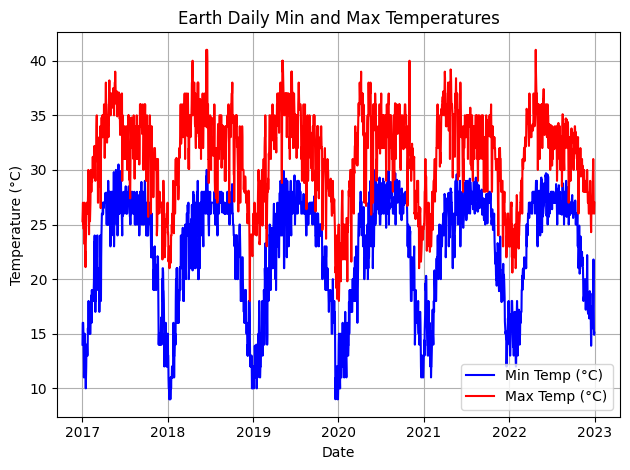

In [22]:
plt.plot(df['Date'], df['Minimum Temperature'], label='Min Temp (°C)', color='blue')
plt.plot(df['Date'], df['Maximum Temperature'], label='Max Temp (°C)', color='red')
plt.title('Earth Daily Min and Max Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Min Temp

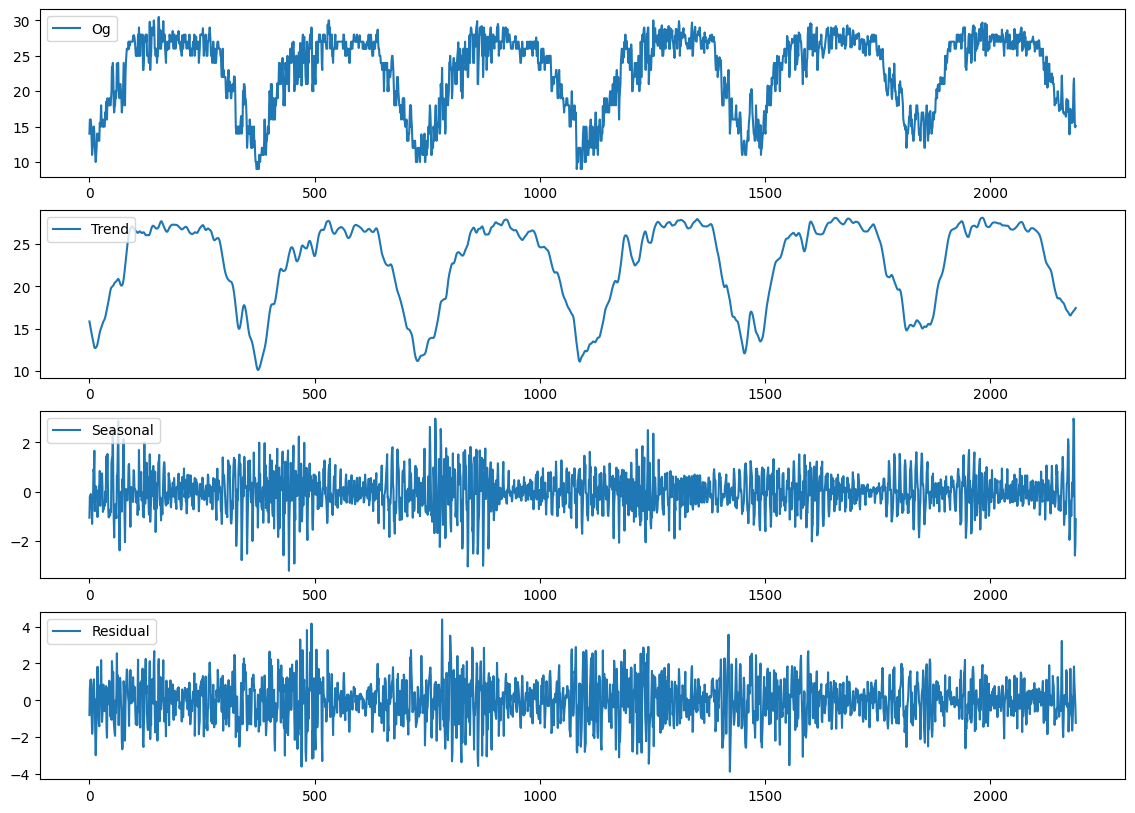

In [23]:
stl = STL(df['Minimum Temperature'], period=12)  # e.g., 12 for monthly data
result=stl.fit()
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(result.observed,label='Og')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend,label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal,label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid,label='Residual')
plt.legend(loc='upper left')

In [24]:
result = adfuller(df['Minimum Temperature'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')  #d=0

ADF Statistic: -3.363546248275154
p-value: 0.012266154660769005


In [ ]:
df['Minimum Temperature']

In [27]:
print(adfuller(df['Minimum Temperature'].dropna())) #D=0

(np.float64(-3.363546248275154), np.float64(0.012266154660769005), 26, 2164, {'1%': np.float64(-3.4333754500434264), '5%': np.float64(-2.862876536558312), '10%': np.float64(-2.56748150557262)}, np.float64(7882.685750890581))


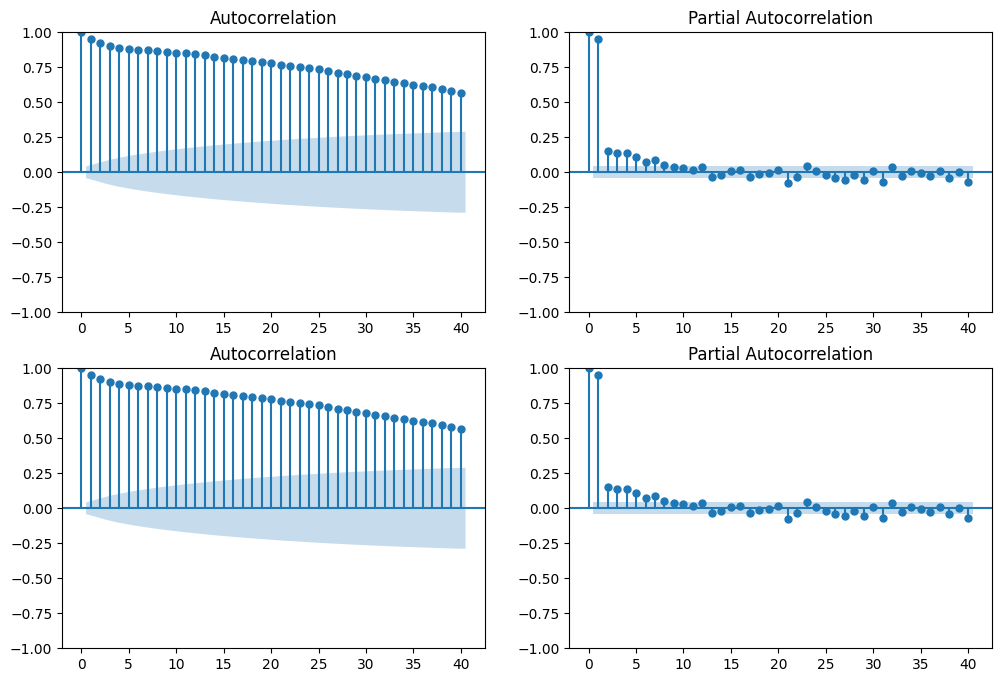

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
# Non-seasonal ACF and PACF
plot_acf(df['Minimum Temperature'].dropna(), lags=40, ax=axes[0,0])
plot_pacf(df['Minimum Temperature'].dropna(), lags=40, ax=axes[0,1])
# Seasonal ACF and PACF (lags at multiples of s)
plot_acf(df['Minimum Temperature'].dropna(), lags=40, ax=axes[1,0])
plot_pacf(df['Minimum Temperature'].dropna(), lags=40, ax=axes[1,1])

plt.show()

In [ ]:
#q=0,1 #p=1,2,3

In [49]:
model = SARIMAX(df['Minimum Temperature'], order=(1,0,0), seasonal_order=(1,1,1,12))
results = model.fit()

print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                  Minimum Temperature   No. Observations:                 2191
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood               -4097.707
Date:                              Sun, 15 Jun 2025   AIC                           8203.413
Time:                                      17:13:39   BIC                           8226.160
Sample:                                           0   HQIC                          8211.729
                                             - 2191                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9493      0.007    130.143      0.000       0.935       0.964
ar.S.L12       0.07

In [50]:
forecast = results.get_forecast(steps=100)  # forecast next 100 days

In [51]:
# Predicted mean (the forecast)
forecast_values = forecast.predicted_mean
#print(forecast_values)
# Confidence intervals
conf_int = forecast.conf_int()
print(pd.DataFrame({
    'Forecasted_values': forecast_values,
    'Conf_Int_lower': conf_int.iloc[:, 0],
    'Conf_Int_upper': conf_int.iloc[:, 1]
}))

      Forecasted_values  Conf_Int_lower  Conf_Int_upper
2191          15.473627       12.399156       18.548097
2192          15.750393       11.511228       19.989558
2193          16.029568       10.965306       21.093830
2194          16.082260       10.375752       21.788768
2195          16.443903       10.215104       22.672702
...                 ...             ...             ...
2286          22.561417       12.289581       32.833253
2287          22.649031       12.377047       32.921015
2288          22.635684       12.363576       32.907792
2289          22.619590       12.347380       32.891800
2290          22.336571       12.064281       32.608861

[100 rows x 3 columns]


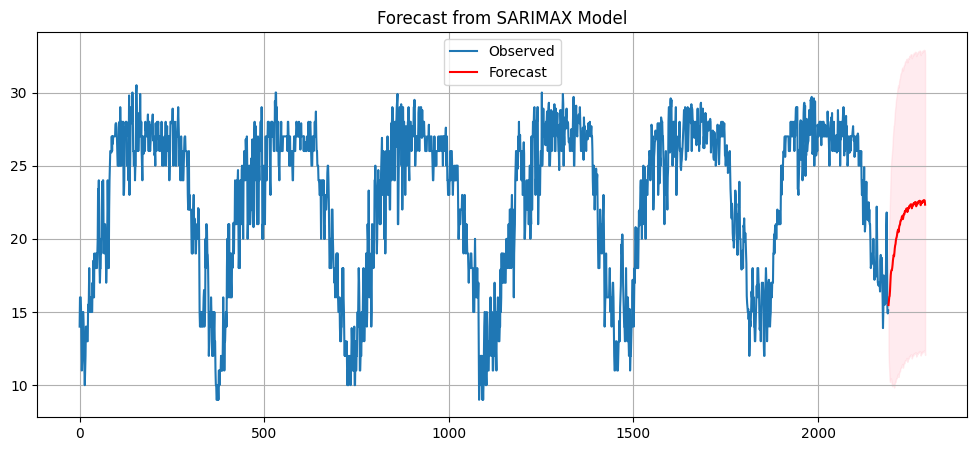

In [52]:
ax = df['Minimum Temperature'].plot(label='Observed', figsize=(12, 5))

# Plot forecast
forecast_values.plot(ax=ax, label='Forecast', color='red')

# Plot confidence intervals
ax.fill_between(conf_int.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1],
                color='pink', alpha=0.3)

plt.title("Forecast from SARIMAX Model")
plt.legend()
plt.grid(True)
plt.show()

In [53]:
train = df['Minimum Temperature'][:-500]  # all but last n values
test = df['Minimum Temperature'][-500:]   # last n values

In [54]:
forecast = results.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [55]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")
print(f"R²   : {r2:.3f}")

MAE: 0.91
RMSE: 1.19
MAPE: 4.21%
R²   : 0.936


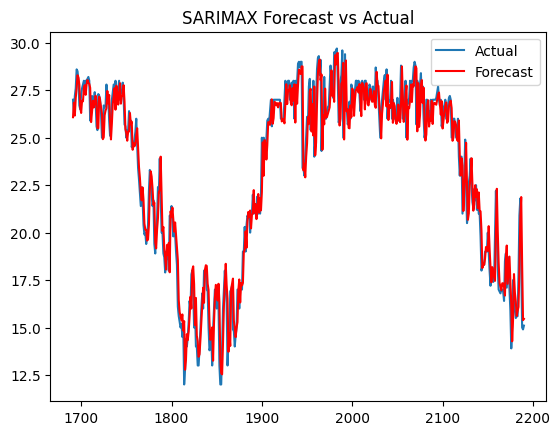

In [56]:
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title("SARIMAX Forecast vs Actual")
plt.show()

### Max Temp

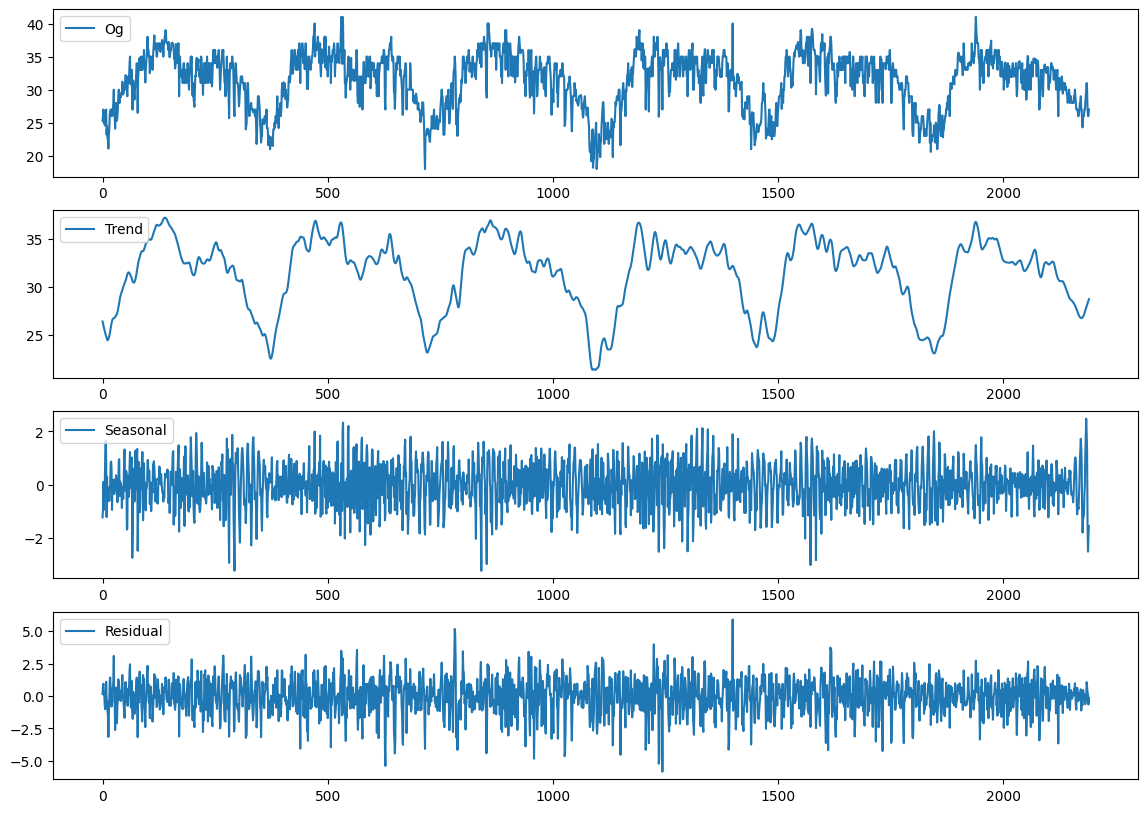

In [57]:
stl = STL(df['Maximum Temperature'], period=12)  # e.g., 12 for monthly data
result=stl.fit()
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(result.observed,label='Og')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend,label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal,label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid,label='Residual')
plt.legend(loc='upper left')

In [58]:
result = adfuller(df['Maximum Temperature'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')  #d=0

ADF Statistic: -3.637264279883326
p-value: 0.005087300913566833


In [59]:
print(adfuller(df['Maximum Temperature'].dropna())) #D=0

(np.float64(-3.637264279883326), np.float64(0.005087300913566833), 14, 2176, {'1%': np.float64(-3.4333587458318977), '5%': np.float64(-2.862869160950496), '10%': np.float64(-2.567477578538941)}, np.float64(8472.856485857339))


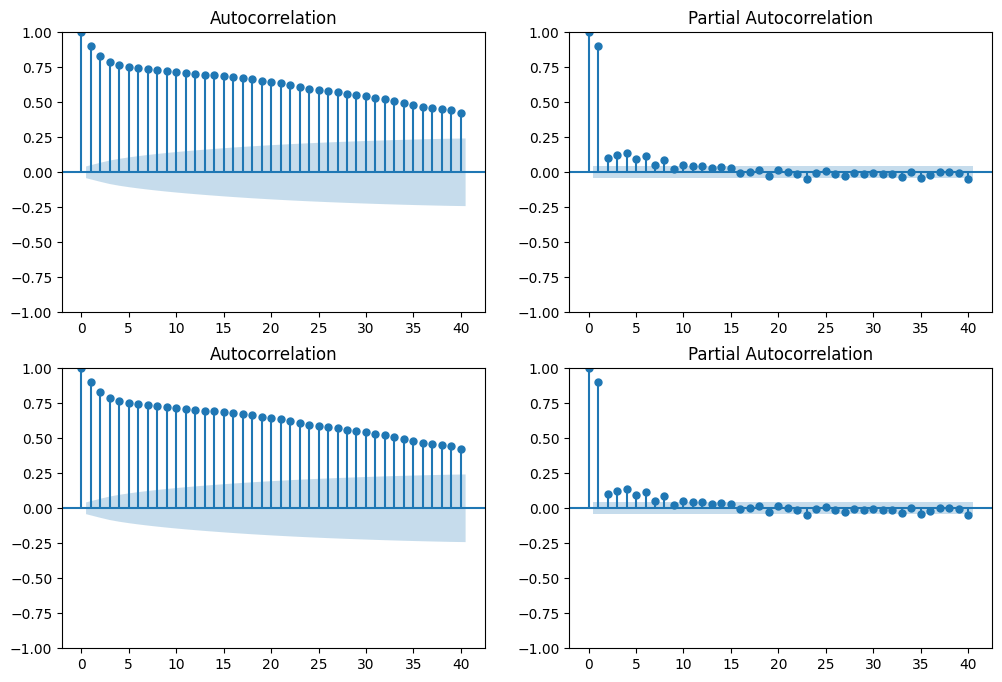

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
# Non-seasonal ACF and PACF
plot_acf(df['Maximum Temperature'].dropna(), lags=40, ax=axes[0,0])
plot_pacf(df['Maximum Temperature'].dropna(), lags=40, ax=axes[0,1])
# Seasonal ACF and PACF (lags at multiples of s)
plot_acf(df['Maximum Temperature'].dropna(), lags=40, ax=axes[1,0])
plot_pacf(df['Maximum Temperature'].dropna(), lags=40, ax=axes[1,1])

plt.show()

In [222]:
model = SARIMAX(df['Maximum Temperature'], order=(2,1,1), seasonal_order=(2,1,1,12))
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                Maximum Temperature   No. Observations:                 2191
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -4290.697
Date:                            Sun, 15 Jun 2025   AIC                           8595.394
Time:                                    20:04:49   BIC                           8635.197
Sample:                                         0   HQIC                          8609.945
                                           - 2191                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6004      0.026     23.536      0.000       0.550       0.650
ar.L2         -0.0685      0.022   

In [229]:
residuals=results.resid
residuals=residuals.reindex(df['Maximum Temperature'].index)
residuals = residuals.fillna(0)

In [230]:
model = SARIMAX(df['Maximum Temperature'], order=(2,1,1), seasonal_order=(2,1,1,12),exog=residuals)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                Maximum Temperature   No. Observations:                 2191
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -3083.749
Date:                            Sun, 15 Jun 2025   AIC                           6183.498
Time:                                    20:07:56   BIC                           6228.987
Sample:                                         0   HQIC                          6200.129
                                           - 2191                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.5481      0.004    127.240      0.000       0.540       0.557
ar.L1          0.1314      0.031   

In [231]:
future_exog=residuals.sample(100)
forecast = results.get_forecast(steps=100,exog=future_exog)  # forecast next 100 days

In [232]:
# Predicted mean (the forecast)
forecast_values = forecast.predicted_mean
#print(forecast_values)
# Confidence intervals
conf_int = forecast.conf_int()
print(pd.DataFrame({
    'Forecasted_values': forecast_values,
    'Conf_Int_lower': conf_int.iloc[:, 0],
    'Conf_Int_upper': conf_int.iloc[:, 1]
}))

      Forecasted_values  Conf_Int_lower  Conf_Int_upper
2191          27.687162       25.745018       29.629306
2192          26.911685       23.581075       30.242295
2193          26.219186       22.249749       30.188623
2194          25.685960       21.313518       30.058401
2195          27.898913       23.102125       32.695701
...                 ...             ...             ...
2286          24.240731        0.414578       48.066885
2287          25.222503        1.213917       49.231089
2288          24.856787        0.661358       49.052216
2289          24.320372       -0.056364       48.697107
2290          25.427962        0.873673       49.982250

[100 rows x 3 columns]


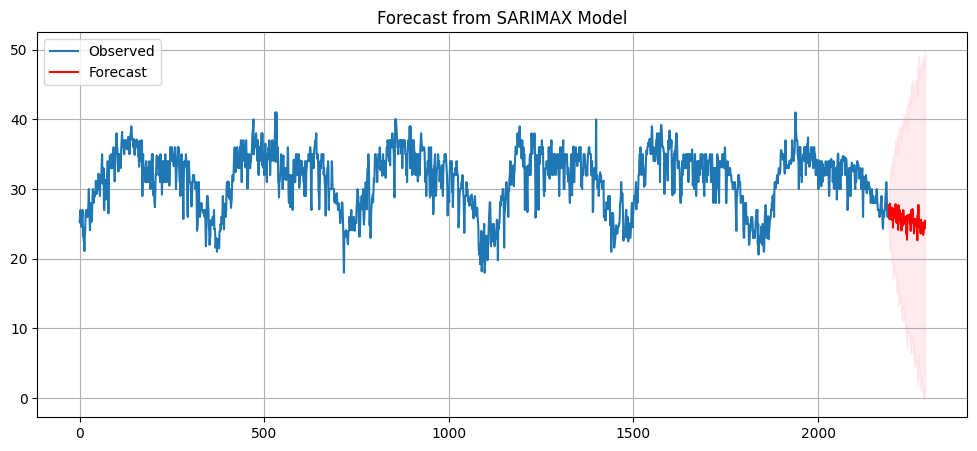

In [233]:
ax = df['Maximum Temperature'].plot(label='Observed', figsize=(12, 5))

# Plot forecast
forecast_values.plot(ax=ax, label='Forecast', color='red')

# Plot confidence intervals
ax.fill_between(conf_int.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1],
                color='pink', alpha=0.3)

plt.title("Forecast from SARIMAX Model")
plt.legend()
plt.grid(True)
plt.show()

In [234]:
train = df['Maximum Temperature'][:-500]  # all but last n values
test = df['Maximum Temperature'][-500:]   # last n values

In [235]:
forecast = results.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [236]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")
print(f"R²   : {r2:.3f}")

MAE: 0.58
RMSE: 0.77
MAPE: 1.93%
R²   : 0.958


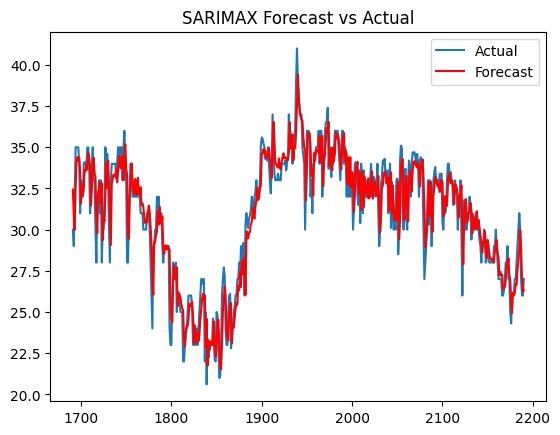

In [143]:
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title("SARIMAX Forecast vs Actual")
plt.show()

### Pressure

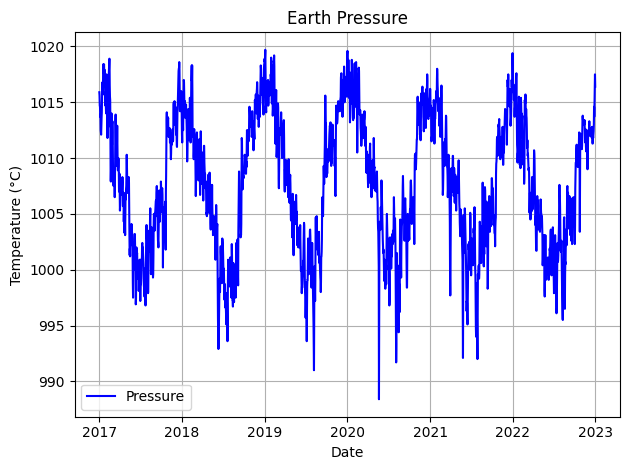

In [145]:
plt.plot(df['Date'], df['Pressure'], label='Pressure', color='blue')
plt.title('Earth Pressure')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

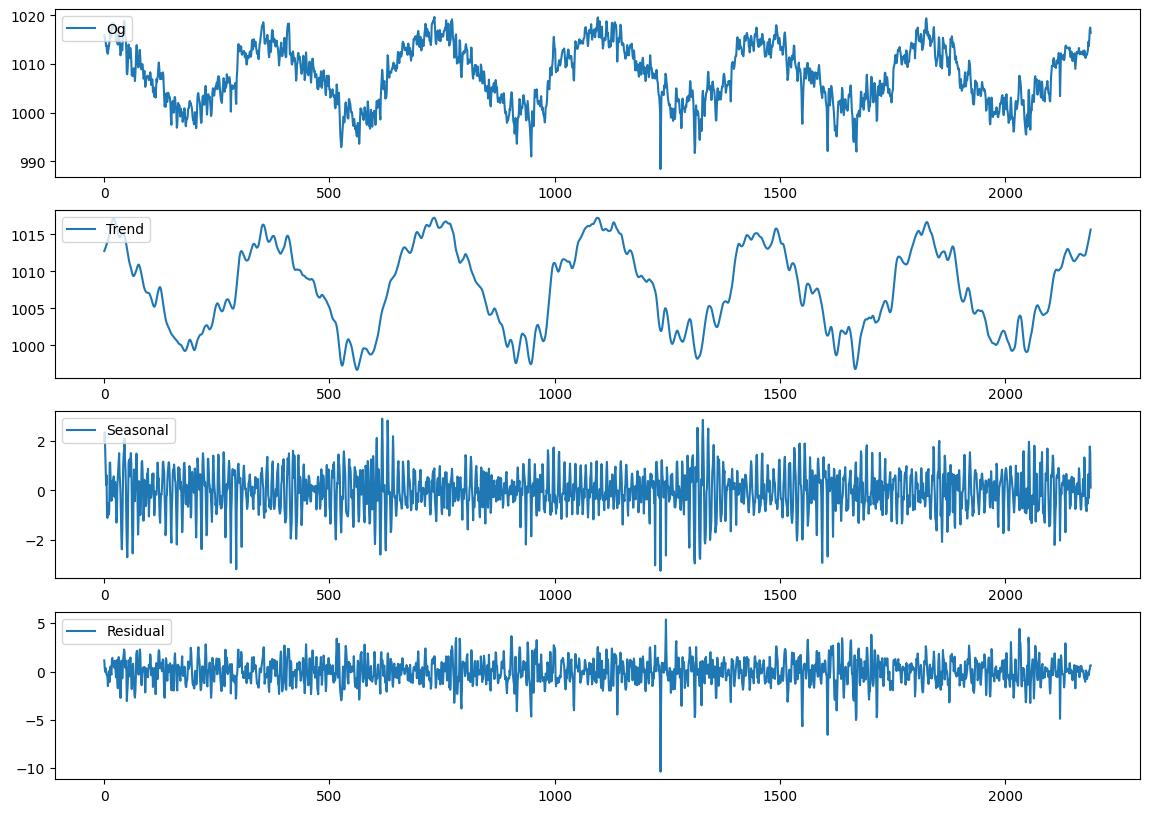

In [146]:
stl = STL(df['Pressure'], period=12)  # e.g., 12 for monthly data
result=stl.fit()
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(result.observed,label='Og')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend,label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal,label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid,label='Residual')
plt.legend(loc='upper left')

In [147]:
result = adfuller(df['Pressure'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')  #d=0

ADF Statistic: -3.2697492406076694
p-value: 0.016286036487711958


In [149]:
print(adfuller(df['Pressure'].dropna())) #D=1

(np.float64(-3.2697492406076694), np.float64(0.016286036487711958), 10, 2180, {'1%': np.float64(-3.4333532186762805), '5%': np.float64(-2.862866720471125), '10%': np.float64(-2.5674762791431696)}, np.float64(7028.250095677069))


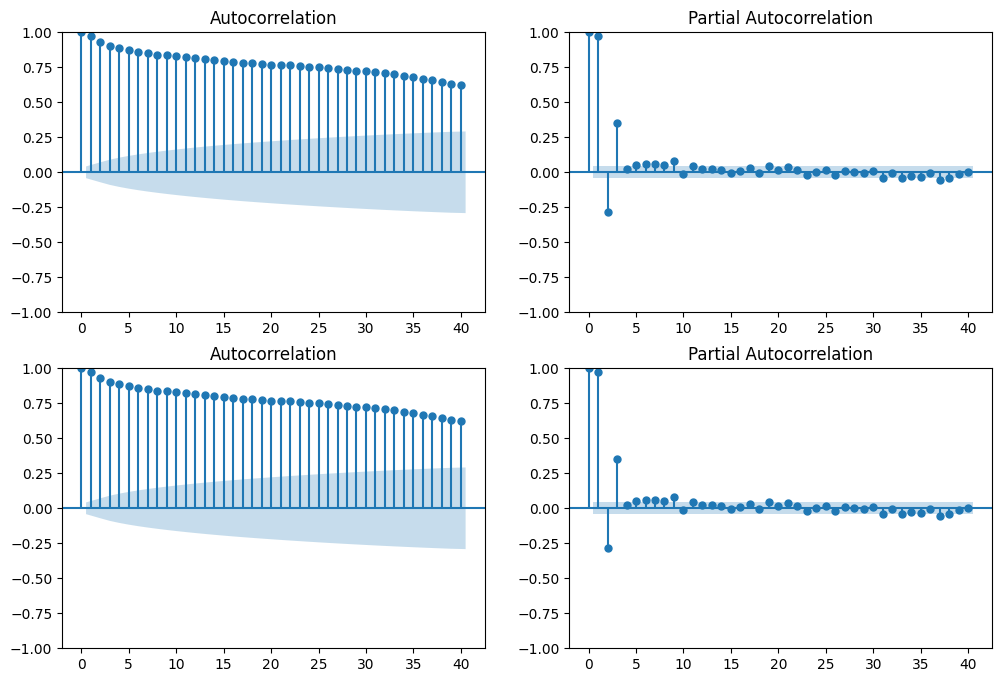

In [150]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
# Non-seasonal ACF and PACF
plot_acf(df['Pressure'].dropna(), lags=40, ax=axes[0,0])
plot_pacf(df['Pressure'].dropna(), lags=40, ax=axes[0,1])
# Seasonal ACF and PACF (lags at multiples of s)
plot_acf(df['Pressure'].dropna(), lags=40, ax=axes[1,0])
plot_pacf(df['Pressure'].dropna(), lags=40, ax=axes[1,1])

plt.show()

In [151]:
model = SARIMAX(df['Pressure'], order=(2,1,1), seasonal_order=(2,1,1,12))
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Pressure   No. Observations:                 2191
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -3589.456
Date:                            Sun, 15 Jun 2025   AIC                           7192.913
Time:                                    17:39:43   BIC                           7232.716
Sample:                                         0   HQIC                          7207.465
                                           - 2191                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4720      0.051      9.184      0.000       0.371       0.573
ar.L2         -0.4021      0.021   

In [152]:
train = df['Pressure'][:-700]  # all but last n values
test = df['Pressure'][-700:]   # last n values

In [153]:
forecast = results.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [154]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")
print(f"R²   : {r2:.3f}")

MAE: 0.93
RMSE: 1.23
MAPE: 0.09%
R²   : 0.950


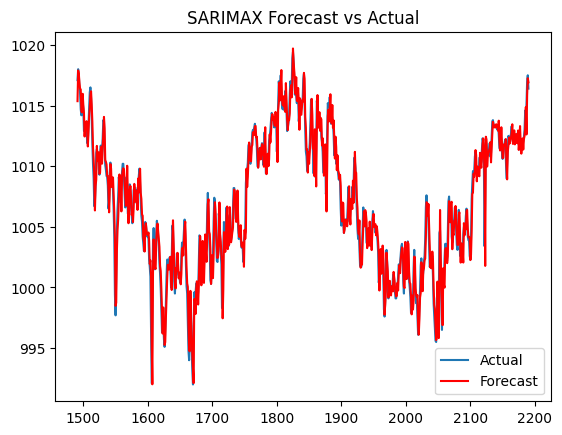

In [155]:
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title("SARIMAX Forecast vs Actual")
plt.show()

### Wind Speed

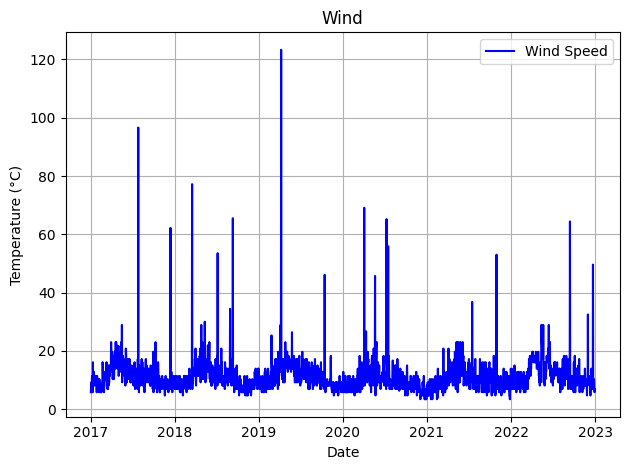

In [158]:
plt.plot(df['Date'], df['Wind Speed'], label='Wind Speed', color='blue')
plt.title('Wind')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

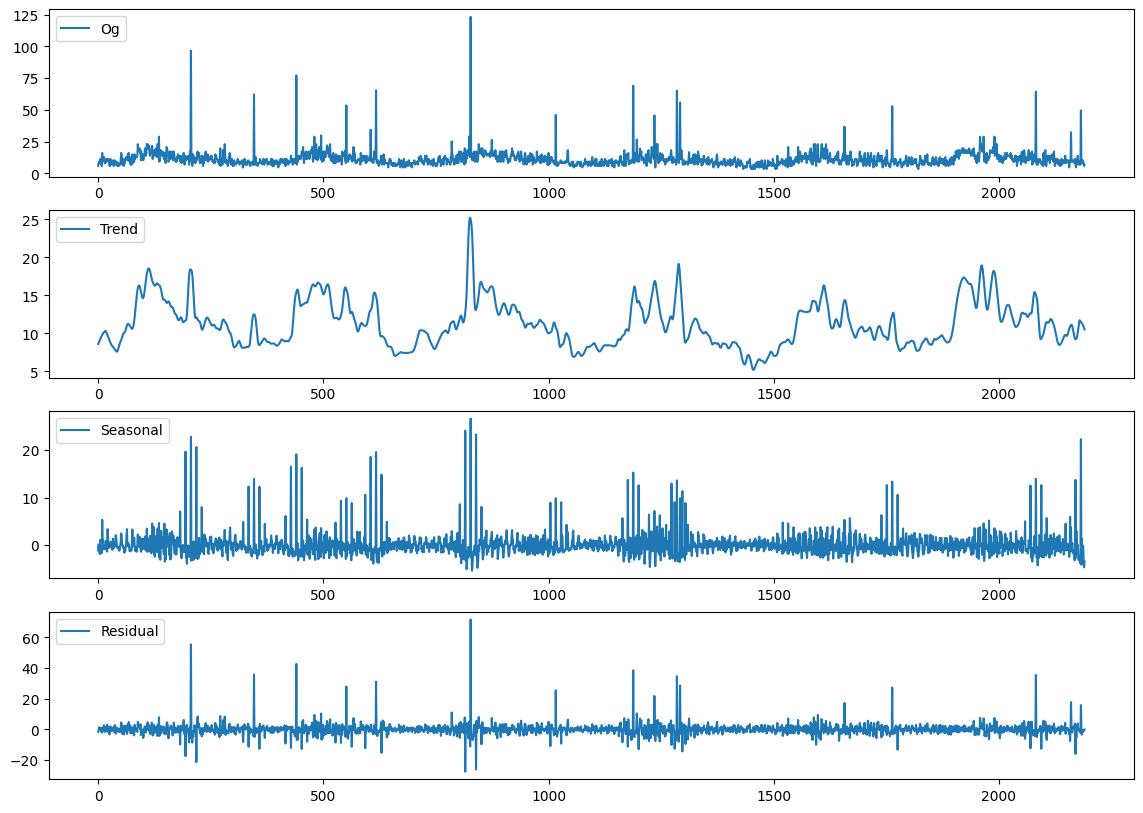

In [159]:
stl = STL(df['Wind Speed'], period=12)  # e.g., 12 for monthly data
result=stl.fit()
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(result.observed,label='Og')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend,label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal,label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid,label='Residual')
plt.legend(loc='upper left')

In [160]:
result = adfuller(df['Wind Speed'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')  #d=0

ADF Statistic: -5.3417043952880086
p-value: 4.485333607910576e-06


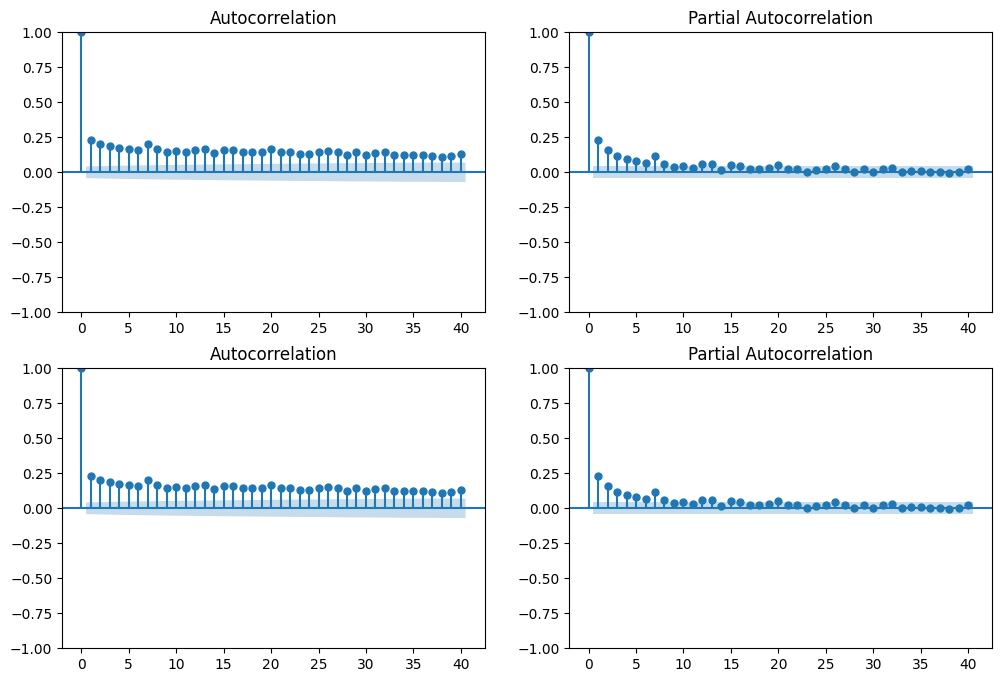

In [161]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
# Non-seasonal ACF and PACF
plot_acf(df['Wind Speed'].dropna(), lags=40, ax=axes[0,0])
plot_pacf(df['Wind Speed'].dropna(), lags=40, ax=axes[0,1])
# Seasonal ACF and PACF (lags at multiples of s)
plot_acf(df['Wind Speed'].dropna(), lags=40, ax=axes[1,0])
plot_pacf(df['Wind Speed'].dropna(), lags=40, ax=axes[1,1])

plt.show()

In [211]:
model = SARIMAX(df['Wind Speed'], order=(1,0,1), seasonal_order=(1,0,1,12))
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Wind Speed   No. Observations:                 2191
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -6940.873
Date:                            Sun, 15 Jun 2025   AIC                          13891.745
Time:                                    20:02:20   BIC                          13920.206
Sample:                                         0   HQIC                         13902.147
                                           - 2191                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9990      0.001    718.973      0.000       0.996       1.002
ma.L1         -0.9296      0.007   

In [212]:
residuals=results.resid
residuals=residuals.reindex(df['Wind Speed'].index)
residuals = residuals.fillna(0) 

In [214]:
model = SARIMAX(df['Wind Speed'], order=(1,0,1), seasonal_order=(1,0,1,12),exog=residuals)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Wind Speed   No. Observations:                 2191
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 -41.109
Date:                            Sun, 15 Jun 2025   AIC                             94.218
Time:                                    20:03:03   BIC                            128.371
Sample:                                         0   HQIC                           106.701
                                           - 2191                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.9642      0.000   4128.854      0.000       0.964       0.965
ar.L1          0.9995      0.000   

In [215]:
future_exog=residuals.sample(100)
forecast = results.get_forecast(steps=100,exog=future_exog)  # forecast next 100 days

In [216]:
# Predicted mean (the forecast)
forecast_values = forecast.predicted_mean
#print(forecast_values)
# Confidence intervals
conf_int = forecast.conf_int()
print(pd.DataFrame({
    'Forecasted_values': forecast_values,
    'Conf_Int_lower': conf_int.iloc[:, 0],
    'Conf_Int_upper': conf_int.iloc[:, 1]
}))

      Forecasted_values  Conf_Int_lower  Conf_Int_upper
2191          12.413509       11.934340       12.892677
2192          15.227884       14.237188       16.218580
2193           7.481954        6.165698        8.798210
2194           8.806510        7.230833       10.382187
2195          11.761889        9.964068       13.559711
...                 ...             ...             ...
2286           8.975886       -4.057435       22.009207
2287          19.476457        6.319485       32.633430
2288          10.252804       -3.034477       23.540085
2289          11.105384       -2.310799       24.521567
2290           8.773781       -4.769937       22.317499

[100 rows x 3 columns]


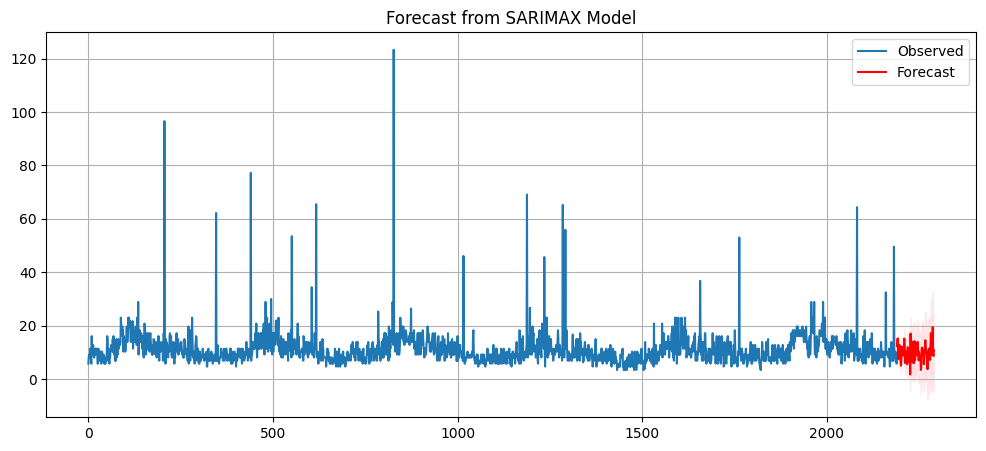

In [217]:
ax = df['Wind Speed'].plot(label='Observed', figsize=(12, 5))

# Plot forecast
forecast_values.plot(ax=ax, label='Forecast', color='red')

# Plot confidence intervals
ax.fill_between(conf_int.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1],
                color='pink', alpha=0.3)

plt.title("Forecast from SARIMAX Model")
plt.legend()
plt.grid(True)
plt.show()

In [218]:
train = df['Wind Speed'][:-700]  # all but last n values
test = df['Wind Speed'][-700:]   # last n values

In [219]:
forecast = results.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [220]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")
print(f"R²   : {r2:.3f}")

MAE: 0.12
RMSE: 0.18
MAPE: 1.08%
R²   : 0.999


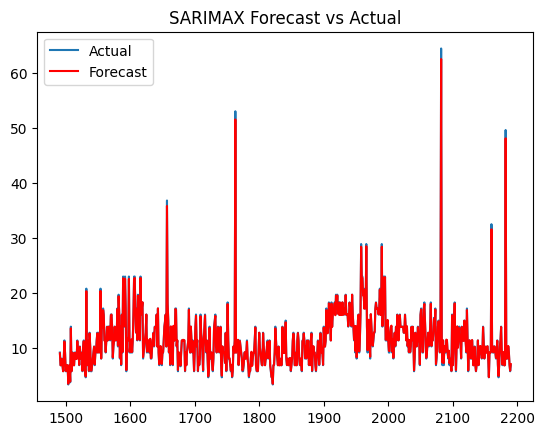

In [221]:
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title("SARIMAX Forecast vs Actual")
plt.show()